In [1]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from attention_conv.model import AttentionConv
from main_dataset import CHMainDataset, SingleCropGenerator
from chunkified_npset import ChunkifiedDataset
from loss import MS_SSIMLoss
import os

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Setup dataset and dataloader

In [3]:
np_set = ChunkifiedDataset()
gen = SingleCropGenerator(np_set[0].shape[0], np_set[0].shape[1])
dataset = CHMainDataset(np_set, gen)

Training Setup

In [3]:
BATCH_LEN = 16 #still depends on its_til_update for true loss batch size
EPOCHS = 20

In [5]:
cl_loader = DataLoader(dataset, batch_size=BATCH_LEN)

In [6]:
model = AttentionConv()

Training utilities
# wow

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = MS_SSIMLoss(channels=24)

NameError: name 'model' is not defined

Training loop definition

In [4]:
dir_to_save = 'conv_concept_models'
if not os.path.isdir(dir_to_save):
    os.makedirs(dir_to_save)

In [5]:
def train_epoch(dataloader, model, optimizer, criterion, losses, epoch_losses, epoch):
    its_til_checkpoint = 20
    its_til_update = 1
    
    epoch_running_loss = 0
    epoch_count = 0
    running_loss = 0
    count = 0
    optimizer.zero_grad()
    for i, (features, targets) in enumerate(dataloader):
        features = features.to(device)
        targets = targets.to(device)

        predictions = model(features)

        loss = criterion(predictions.unsqueeze(2), targets.unsqueeze(2))
        loss.backward()

        curr_len = features.shape[0]
        running_loss += curr_len * loss.item()
        count += curr_len
        epoch_running_loss += curr_len * loss.item()
        epoch_count += curr_len
        
        losses.append(loss.item())
        
        if i % its_til_update == its_til_update-1:
            print(f'Peforming update on model with batch_size - {its_til_update * BATCH_LEN}')
            optimizer.step()
            optimizer.zero_grad()
        
        print(f'Iteration {i} - batch size: {curr_len}')
        
        if i % its_til_checkpoint == its_til_checkpoint-1:
            curr_loss = running_loss / count
            print(f'Current loss after {its_til_checkpoint} iterations: {curr_loss}')

            plt.plot(losses, 'b-')
            plt.title("Loss over iterations")
            plt.show()

            file_name = f'epoch-{epoch}_iteration-{i}_loss-{curr_loss}'
            torch.save(model.state_dict(), os.path.join(dir_to_save, file_name))

            running_loss = 0
            count = 0
            
        if i == 120: #rando early break lul
            break
    
    epoch_losses.append(epoch_running_loss / epoch_count)

In [8]:
losses = []
train_epoch(cl_loader, model, optimizer, criterion, losses, 0)

NameError: name 'model' is not defined

In [6]:
def train(epochs, dataset, batch_size, model, optimizer, criterion):
    losses = []
    epoch_losses = []
    dataloader = DataLoader(dataset, batch_size=batch_size)
    for epoch in range(epochs):
        print(f'Entering epoch {epoch}')
        train_epoch(dataloader, model, optimizer, criterion, losses, epoch_losses, epoch)
        print(f'Loss for epoch {epoch} - {epoch_losses[-1]}')
        plt.plot(epoch_losses, 'r-')
        plt.title('Epoch Losses')
        plt.show()
    
    return losses

In [7]:
np_set = ChunkifiedDataset()
gen = SingleCropGenerator(np_set[0].shape[0], np_set[0].shape[1])
dataset = CHMainDataset(np_set, gen)
dataset[0][1].shape

(24, 64, 64)

In [8]:
# preprocess = ImagesPreprocess()
# model = PerceiverCH(preprocess, latent_dim=(32, 128), heads=8, wide_factor=4, latent_count=6)
model = AttentionConv()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
msssim = MS_SSIMLoss(channels=24)
l1 = torch.nn.L1Loss()
criterion = lambda pred, target: msssim(pred,target) #+ l1(pred,target) 

Entering epoch 0
Peforming update on model with batch_size - 16
Iteration 0 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 1 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 2 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 3 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 4 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 5 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 6 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 7 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 8 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 9 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 10 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 11 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 12 - batch s

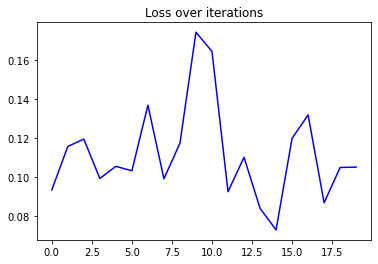

Peforming update on model with batch_size - 16
Iteration 20 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 21 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 22 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 23 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 24 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 25 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 26 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 27 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 28 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 29 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 30 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 31 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 32 - batch size: 16

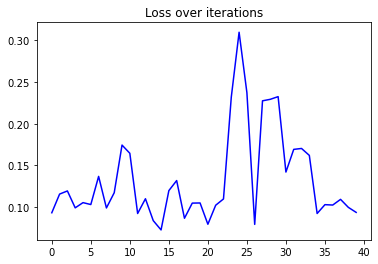

Peforming update on model with batch_size - 16
Iteration 40 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 41 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 42 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 43 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 44 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 45 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 46 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 47 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 48 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 49 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 50 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 51 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 52 - batch size: 16

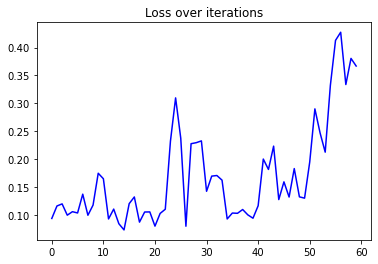

Peforming update on model with batch_size - 16
Iteration 60 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 61 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 62 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 63 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 64 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 65 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 66 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 67 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 68 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 69 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 70 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 71 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 72 - batch size: 16

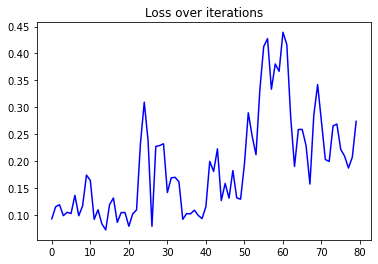

Peforming update on model with batch_size - 16
Iteration 80 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 81 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 82 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 83 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 84 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 85 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 86 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 87 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 88 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 89 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 90 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 91 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 92 - batch size: 16

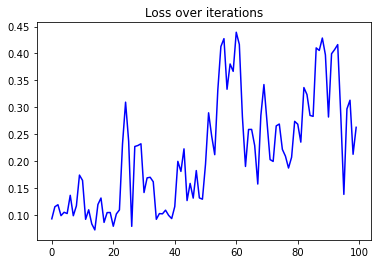

Peforming update on model with batch_size - 16
Iteration 100 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 101 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 102 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 103 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 104 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 105 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 106 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 107 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 108 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 109 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 110 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 111 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 112 - b

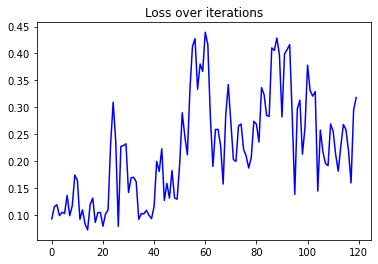

Peforming update on model with batch_size - 16
Iteration 120 - batch size: 16
Loss for epoch 0 - 0.2231076167634696


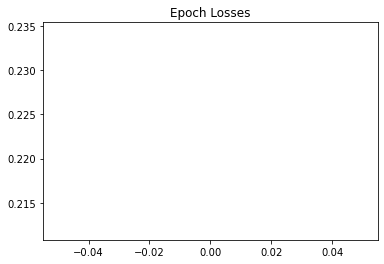

Entering epoch 1
Peforming update on model with batch_size - 16
Iteration 0 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 1 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 2 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 3 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 4 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 5 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 6 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 7 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 8 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 9 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 10 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 11 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 12 - batch s

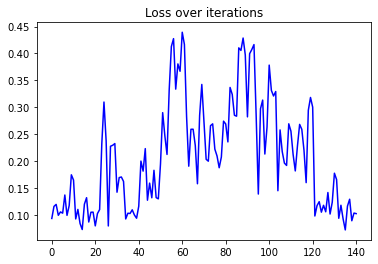

Peforming update on model with batch_size - 16
Iteration 20 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 21 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 22 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 23 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 24 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 25 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 26 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 27 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 28 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 29 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 30 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 31 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 32 - batch size: 16

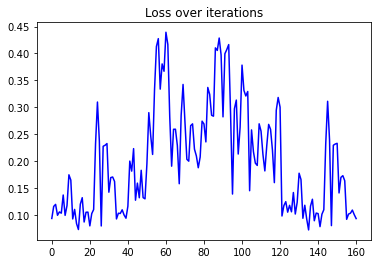

Peforming update on model with batch_size - 16
Iteration 40 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 41 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 42 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 43 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 44 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 45 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 46 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 47 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 48 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 49 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 50 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 51 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 52 - batch size: 16

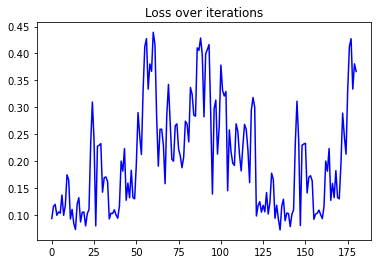

Peforming update on model with batch_size - 16
Iteration 60 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 61 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 62 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 63 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 64 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 65 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 66 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 67 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 68 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 69 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 70 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 71 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 72 - batch size: 16

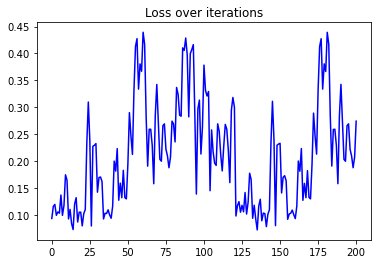

Peforming update on model with batch_size - 16
Iteration 80 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 81 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 82 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 83 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 84 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 85 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 86 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 87 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 88 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 89 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 90 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 91 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 92 - batch size: 16

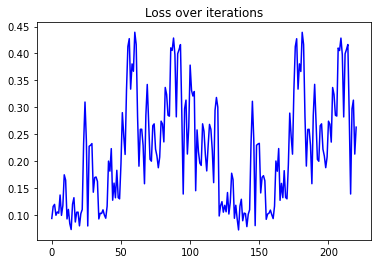

Peforming update on model with batch_size - 16
Iteration 100 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 101 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 102 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 103 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 104 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 105 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 106 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 107 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 108 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 109 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 110 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 111 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 112 - b

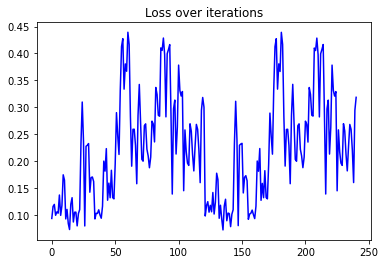

Peforming update on model with batch_size - 16
Iteration 120 - batch size: 16
Loss for epoch 1 - 0.22360335844607393


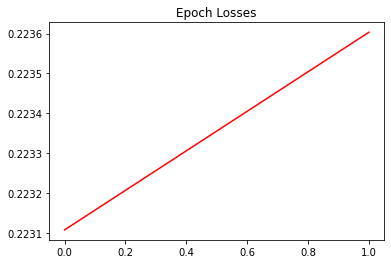

Entering epoch 2
Peforming update on model with batch_size - 16
Iteration 0 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 1 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 2 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 3 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 4 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 5 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 6 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 7 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 8 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 9 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 10 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 11 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 12 - batch s

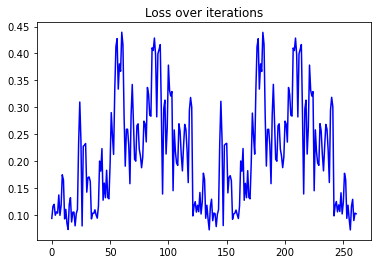

Peforming update on model with batch_size - 16
Iteration 20 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 21 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 22 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 23 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 24 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 25 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 26 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 27 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 28 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 29 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 30 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 31 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 32 - batch size: 16

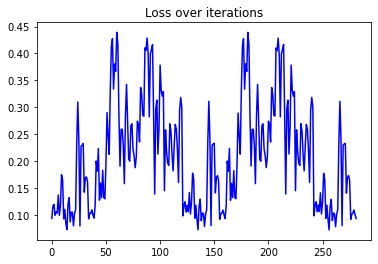

KeyboardInterrupt: 

In [16]:
train(EPOCHS, dataset, BATCH_LEN, model, optimizer, criterion)

#### Lets see the results


tensor([[231.2300, 183.6609, 188.1163,  ..., 172.8685, 174.2672, 183.2836],
        [199.0885, 106.2878, 183.2273,  ..., 174.4227, 177.3799, 178.3065],
        [169.3176, 172.6771, 178.2169,  ..., 174.3508, 177.4067, 176.8710],
        ...,
        [174.0647, 173.5348, 167.2717,  ..., 174.9025, 167.4093, 184.7676],
        [189.0590, 170.7145, 179.6351,  ..., 163.8719, 158.0318, 243.1685],
        [106.4657, 204.0184, 176.3059,  ..., 160.0798, 183.6598, 109.5706]])
tensor([[235.1063, 186.9922, 192.2513,  ..., 176.1667, 177.3301, 186.8730],
        [203.3911, 109.9640, 187.2241,  ..., 177.6644, 180.6588, 182.1674],
        [173.2933, 176.8683, 181.6305,  ..., 177.9316, 180.9602, 180.7846],
        ...,
        [177.7277, 177.8462, 171.6819,  ..., 178.9809, 172.4805, 189.3933],
        [192.4848, 174.5938, 183.5227,  ..., 168.5635, 162.4523, 247.9436],
        [110.0003, 208.2014, 179.8227,  ..., 164.9467, 188.1752, 113.6224]])
tensor([[238.8633, 190.7386, 196.4245,  ..., 179.3012, 179.4

tensor([[231.2299, 183.6609, 188.1163,  ..., 172.8685, 174.2672, 183.2836],
        [199.0885, 106.2878, 183.2273,  ..., 174.4227, 177.3799, 178.3065],
        [169.3176, 172.6771, 178.2169,  ..., 174.3508, 177.4066, 176.8710],
        ...,
        [174.0648, 173.5348, 167.2717,  ..., 174.9025, 167.4093, 184.7676],
        [189.0591, 170.7145, 179.6351,  ..., 163.8719, 158.0318, 243.1685],
        [106.4657, 204.0184, 176.3059,  ..., 160.0797, 183.6598, 109.5706]])
tensor([[235.1064, 186.9922, 192.2513,  ..., 176.1667, 177.3301, 186.8730],
        [203.3911, 109.9640, 187.2241,  ..., 177.6644, 180.6588, 182.1674],
        [173.2934, 176.8683, 181.6305,  ..., 177.9317, 180.9602, 180.7846],
        ...,
        [177.7277, 177.8462, 171.6819,  ..., 178.9809, 172.4805, 189.3932],
        [192.4848, 174.5938, 183.5227,  ..., 168.5635, 162.4522, 247.9435],
        [110.0003, 208.2014, 179.8227,  ..., 164.9467, 188.1752, 113.6224]])
tensor([[238.8633, 190.7387, 196.4245,  ..., 179.3012, 179.4

tensor([[231.2299, 183.6609, 188.1162,  ..., 172.8685, 174.2672, 183.2836],
        [199.0885, 106.2878, 183.2273,  ..., 174.4227, 177.3799, 178.3065],
        [169.3176, 172.6771, 178.2169,  ..., 174.3508, 177.4066, 176.8710],
        ...,
        [174.0647, 173.5348, 167.2716,  ..., 174.9026, 167.4093, 184.7676],
        [189.0590, 170.7145, 179.6351,  ..., 163.8719, 158.0318, 243.1685],
        [106.4657, 204.0184, 176.3059,  ..., 160.0797, 183.6599, 109.5706]])
tensor([[235.1064, 186.9921, 192.2513,  ..., 176.1668, 177.3301, 186.8730],
        [203.3911, 109.9640, 187.2241,  ..., 177.6645, 180.6588, 182.1674],
        [173.2934, 176.8683, 181.6305,  ..., 177.9317, 180.9602, 180.7846],
        ...,
        [177.7277, 177.8462, 171.6819,  ..., 178.9809, 172.4805, 189.3932],
        [192.4848, 174.5938, 183.5227,  ..., 168.5635, 162.4522, 247.9435],
        [110.0003, 208.2014, 179.8227,  ..., 164.9467, 188.1752, 113.6224]])
tensor([[238.8633, 190.7386, 196.4245,  ..., 179.3012, 179.4

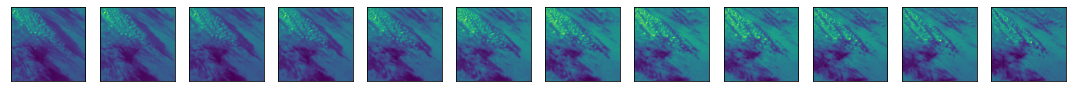

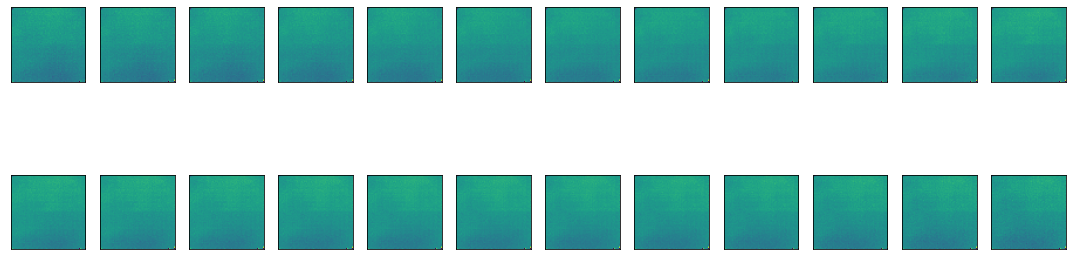

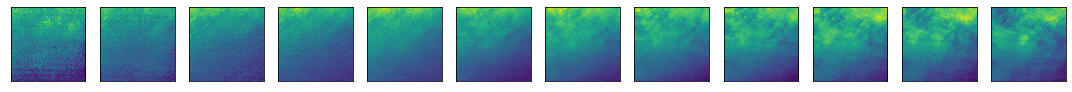

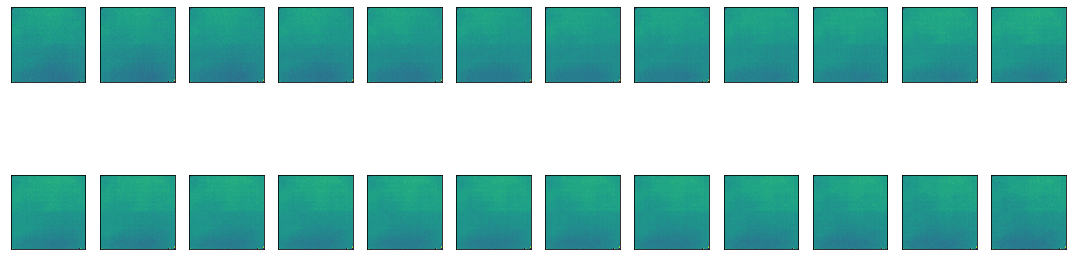

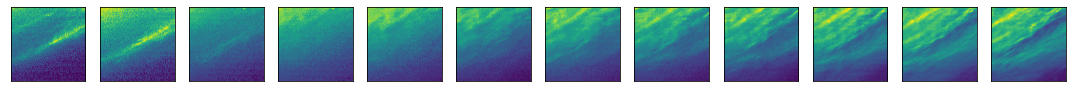

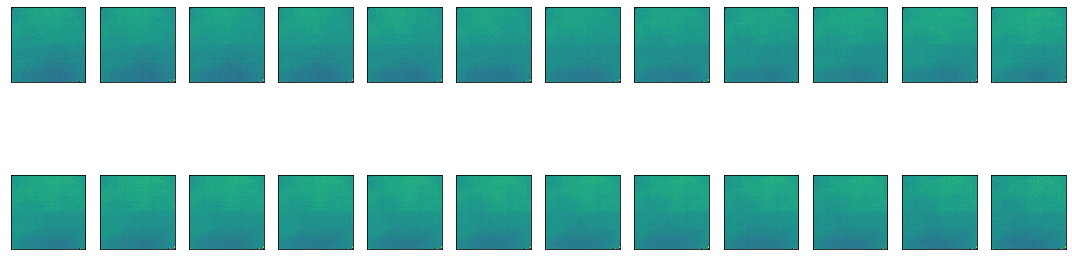

In [15]:
model.eval()
garbo = [dataset[i] for i in range(10, 13)]
for i, (features, targets) in enumerate(garbo):
    if i == 3:
        break
    
    fig, axs = plt.subplots(1, 12, figsize=(15, 3))
    for f_no, ax in enumerate(axs):
        ax.imshow(features[f_no], cmap='viridis')
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
    fig.tight_layout()
    fig.show()
    
    features = torch.tensor(features).unsqueeze(0).to(device)
    predictions = model(features)
    fig, axs = plt.subplots(2, 12, figsize=(15, 6))
    predictions = predictions.squeeze()
    predictions = predictions.detach().cpu()
    p_no = 0
    for chonky in axs:
        for ax in chonky:
            ax.imshow(predictions[p_no], cmap='viridis')
            ax.get_yaxis().set_visible(False)
            ax.get_xaxis().set_visible(False)
            print(predictions[p_no])
            p_no += 1
    fig.tight_layout()
    
    fig.show()

In [17]:
garbo = model.transformer.in_pe.expand(5, -1, -1)
garbo.device

device(type='cuda', index=0)

In [14]:
print(torch.mean(model.process.q_out))

tensor(-1.7162e-05, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
plt.plot(losses, 'b-')
plt.set_title("THe losses wow")
plt.show()